## <font color="yellow"> Personalized emails - CLUSTERING

In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
# Parameters 
LabeledFileName =  r'./intermediate_data/Amazon_Reviews_Labeled.csv'
CusteredFileName = './intermediate_data/Amazon_Reviews_Clustered.csv'
CusteringResultsFileName = './intermediate_data/Amazon_Reviews_ClusteringResults.csv'

pd.options.display.float_format = '{:,.2f}'.format 

## <font color="yellow"> Data Loading & Preview

In [84]:
print(df["UserId"].value_counts(dropna=False).head(10),'\n')

UserId
A1XV4W7JWX341C    10
A3SSEJ8IEM4YGW     9
A2XVOWD40JCFSZ     9
A3GFZIL1E0Z5V8     9
AUINI96NMGXUI      9
AEY5NHLOAWM21      8
A2YRK0YLBN5CC2     7
A3RKYD8IUC5S0N     7
A32NC2UF34RJQY     7
A1HHNY1GVD3UIS     6
Name: count, dtype: int64 



In [83]:
# LOADING Labeled File
df = pd.read_csv(LabeledFileName)

df = df.drop(["Unnamed: 0"], axis=1)
# Initial Data Profiling 
print(f"Shape: {df.shape}\n")
print(f"DataFrame Info: {df.info()}\n")

# Missing Values Check
print(f"Original Missing Values:\n{'-'*40}\n{df.isnull().sum()}\n")
print(f"Confidence value counts:\n{'-'*40}")
print(df["Confidence"].value_counts(dropna=False).head(10),'\n')

Shape: (1000, 9)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ProductId       1000 non-null   object
 1   UserId          1000 non-null   object
 2   Score           1000 non-null   int64 
 3   Comment         1000 non-null   object
 4   Product         1000 non-null   object
 5   Sentiment       1000 non-null   object
 6   Aggressiveness  1000 non-null   int64 
 7   Satisfaction    1000 non-null   int64 
 8   Confidence      1000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 70.4+ KB
DataFrame Info: None

Original Missing Values:
----------------------------------------
ProductId         0
UserId            0
Score             0
Comment           0
Product           0
Sentiment         0
Aggressiveness    0
Satisfaction      0
Confidence        0
dtype: int64

Confidence value counts:
-----------------------------------

## <font color="yellow"> Data Preprocessing

In [38]:
# It seems that there in no need for handling missing values 

# Filter out low confidence rows (confidence should be > 2 to count for the clustering process), since there is a small number of records 
# with Confidence <=2
df = df[df['Confidence'] > 2]
df = df.drop('Confidence', axis =1)

# Mapping Sentiment to numerical values
SentimentNum = df["Sentiment"].map({'very negative': 1, 'negative': 2, 'neutral': 3, 'positive': 4, 'very positive': 5})
df.insert(5, "SentimentNum", SentimentNum)
df["SentimentNum"] = df.SentimentNum.astype(int)

# Filter rows where the absolute difference between SentimentNum | Satisfaction and Score is within a  discrepancy_threshold
discrepancy_threshold = 2
df = df[abs(df['SentimentNum'] - df['Score']) <= discrepancy_threshold] 
df = df[abs(df['Satisfaction'] - df['Score']) <= discrepancy_threshold] 

In [39]:
# FOr NULL values here to consider the dropna
#df['SentimentNum'] = df['SentimentNum'].fillna(0)
#df['SentimentNum'] = df['SentimentNum'].replace([np.inf, -np.inf], 0)

# Define groups of features to facilitate next processes
cat_features = df.select_dtypes(exclude="number").columns.drop(['ProductId', 'Comment', 'UserId'])
num_features = df.select_dtypes(include='number').columns

# Value Counts
print(f"Categorial Features Value Counts\n{'-'*40}")
for col in cat_features:
    print(df[col].value_counts(dropna=False).head(10),'\n')

Categorial Features Value Counts
----------------------------------------
Product
coffee          20
tea             20
cookies         12
liver treats     9
popcorn          9
Rodeo Drive      9
faucet           9
dog food         8
Kind Plus        8
HS lunch         7
Name: count, dtype: int64 

Sentiment
positive         377
very positive    358
negative         121
very negative     57
neutral           48
Name: count, dtype: int64 



In [40]:
df.describe()

,Score,SentimentNum,Aggressiveness,Satisfaction
count,961.00,961.00,961.00,961.00
mean,4.25,3.89,2.17,4.22
std,1.25,1.20,2.12,1.38
min,1.00,1.00,1.00,1.00
25%,4.00,4.00,1.00,4.00
50%,5.00,4.00,1.00,5.00
75%,5.00,5.00,2.00,5.00
max,5.00,5.00,9.00,5.00


## <font color="yellow">Data Visualization

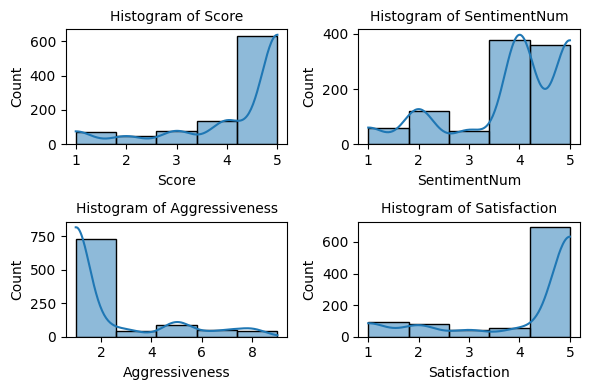

In [41]:
def show_histograms():
    fig, axes = plt.subplots(2, 2, figsize=(6, 4))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Plot histograms for each feature
    for i, feature in enumerate(num_features):
        sns.histplot(df[num_features[i]], bins=5, kde=True, ax=axes[i])
        axes[i].set_title(f'Histogram of {num_features[i]}', fontsize=10)

    # Adjust layout
    plt.tight_layout()

    # Display the plot
    plt.show()

show_histograms()

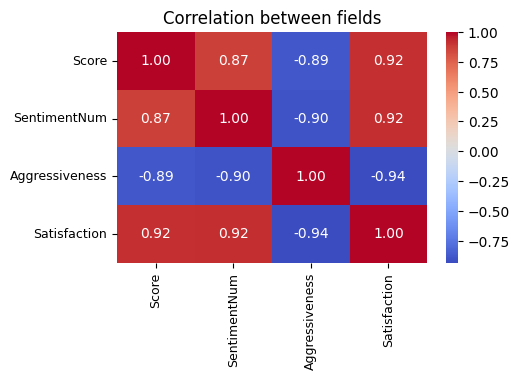

In [42]:
# Calculate correlations
correlation_matrix = df[num_features].corr()

# Plotting heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(correlation_matrix, annot=True, annot_kws={"size": 10},  cmap='coolwarm', fmt=".2f")
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.title('Correlation between fields')
plt.show()

## <font color="yellow"> Feature Engineering

In [44]:
# Feature scaling
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df[num_features])

## <font color="yellow"> Custering
First we apply the **Elbow Method:**  plotting the within-cluster sum of squares (WCSS) against the number of clusters to find the optimal number of clusters. in the plot.

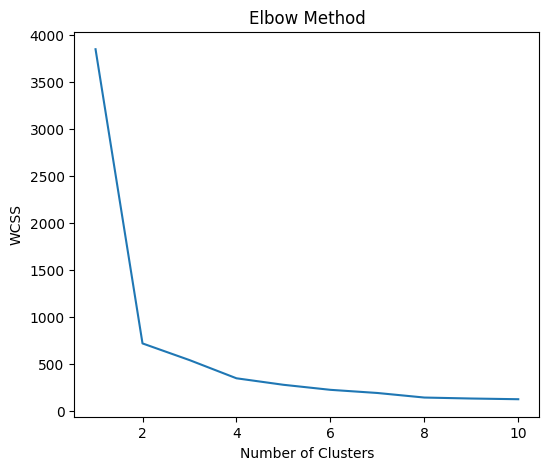

In [50]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(scaled_df)
    wcss.append(kmeans.inertia_)
    
plt.figure(figsize=(6, 5))
plt.plot(range(1, 11), wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

In [80]:
# It seems that 5 clusters is the optimal number 
k = 5

# K-means clustering
kmeans = KMeans(n_clusters=k, random_state=0)  # Example with 3 clusters
kmeans.fit(scaled_df)

# Adding cluster labels to the original DataFrame
df['Cluster'] = kmeans.labels_

# Saving the results 
df.to_csv(CusteredFileName, index=False)

# Display the DataFrame with cluster labels
df.head()

,ProductId,UserId,Score,Comment,Product,SentimentNum,Sentiment,Aggressiveness,Satisfaction,Cluster
0,B000S859NC,A2H7STZ2URUCOE,5,GREAT TEA;Rooibos Natural Red tea is something...,Rooibos Natural Red tea,4,positive,1,5,4
1,B002ZOCEMG,A1LIP0F4R542OQ,1,:(;I just got this coffee a few days ago. I ha...,coffee,1,very negative,7,1,3
2,B001EO5RSQ,A33W5JAFGHYRQZ,5,Love this Cereal!;There is nothing else like t...,Cereal,5,very positive,2,5,0
3,B000HB9TLI,A353IAF5Y1XE53,1,Don't like the taste;I do not like sour taste ...,sour taste product,1,very negative,7,1,3
4,B000SDKDM4,A18NG9I9MT2V8I,5,Deeeee-lish!;For far too long I was a devotee ...,Lavazza,5,very positive,1,5,0


In [81]:
# KMeans results overview
aggregated_df = df.groupby(['Cluster']).agg({
    'SentimentNum': ['mean', 'std'],
    'Aggressiveness': ['mean', 'std'],
    'Satisfaction': ['mean', 'std'],
    'Score': ['mean', 'std','count'],
}).reset_index()
aggregated_df.columns = ['Cluster', 
                         'Sentiment_mean', 'Sentiment_std', 
                         'Aggressiveness_mean', 'Aggressiveness_std', 
                         'Satisfaction_mean', 'Satisfaction_std', 
                         'Score_mean', 'Score_std','Count'
                        ]
# Moving 'Count' to be the second column of the results
aggregated_df.insert(1, 'Count', aggregated_df.pop('Count'))

aggregated_df.to_csv(CusteringResultsFileName, index=False)
aggregated_df

,Cluster,Count,Sentiment_mean,Sentiment_std,Aggressiveness_mean,Aggressiveness_std,Satisfaction_mean,Satisfaction_std,Score_mean,Score_std
0,0,353,5.00,0.00,1.02,0.14,5.00,0.00,4.97,0.17
1,1,94,2.14,0.35,4.91,0.85,2.13,0.59,2.86,0.63
2,2,133,3.78,0.50,1.59,0.81,4.35,0.78,3.91,0.40
3,3,97,1.41,0.49,7.15,1.03,1.15,0.36,1.26,0.46
4,4,284,4.00,0.06,1.25,0.80,4.95,0.22,5.00,0.00


## <font color="yellow"> Validation
**Silhouette Score:** This metric provides an indication of how similar each point is to points in its own cluster compared to points in other clusters. A higher silhouette score indicates better-defined clusters.


Silhouette Score: 0.687 




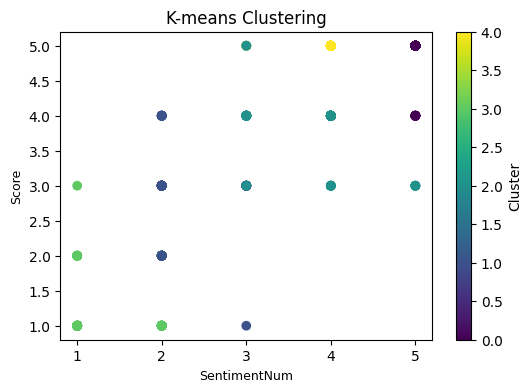

In [82]:
# Validate the results using silhouette score
silhouette_avg = silhouette_score(scaled_df, kmeans.labels_)
print(f"\nSilhouette Score: {silhouette_avg:.3f}","\n\n")

# Optional: Plot clusters (for visualization if features are 2D or 3D)
plt.figure(figsize=(6, 4))
plt.scatter(df['SentimentNum'], df['Score'], c=df['Cluster'], cmap='viridis')
plt.xlabel('SentimentNum', fontsize=9)
plt.ylabel('Score', fontsize=9)
plt.title('K-means Clustering')
plt.colorbar(label='Cluster')
plt.show()